# Libraries

In [ ]:
# tinh toan
import numpy as np
import pandas as pd
from scipy import linalg
from kneed import KneeLocator
# xu ly du lieu
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
# metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    silhouette_score,
    davies_bouldin_score
)
# plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Class MyPCA

In [ ]:
class MyPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.cumulative_explained_variance_ = None
        self.all_eigvals_sorted_ = None

    def fit(self, X):
        # 1) Tâm dữ liệu
        self.mean_ = np.mean(X, axis=0)
        Xc = X - self.mean_
        # 2) Ma trận hiệp phương sai
        n_samples = X.shape[0]
        # Nên kiểm tra Xc.shape[1] > 0
        if Xc.shape[1] == 0:
            # Xử lý trường hợp không có features
            self.components_ = np.array([])
            self.explained_variance_ = np.array([])
            self.explained_variance_ratio_ = np.array([])
            self.cumulative_explained_variance_ = np.array([])
            self.all_eigvals_sorted_ = np.array([])
            return self

        C = np.dot(Xc.T, Xc) / (n_samples - 1)
        # 3) Tính trị riêng và vector riêng
        eigvals, eigvecs = np.linalg.eigh(C) # eigh cho ma trận đối xứng

        # 4) Sắp xếp giảm dần
        idx = np.argsort(eigvals)[::-1]
        self.all_eigvals_sorted_ = eigvals[idx] # Lưu tất cả trị riêng đã sắp xếp
        eigvecs_sorted = eigvecs[:, idx]

        # Tính tổng phương sai của dữ liệu gốc (tổng tất cả các trị riêng)
        total_variance_original_data = np.sum(self.all_eigvals_sorted_)
        if total_variance_original_data == 0: # Tránh chia cho 0
            total_variance_original_data = 1e-10

        # 5) Chọn số thành phần
        if self.n_components is not None and self.n_components < X.shape[1] :
            self.explained_variance_ = self.all_eigvals_sorted_[:self.n_components]
            self.components_ = eigvecs_sorted[:, :self.n_components].T
        else: # Nếu n_components không được set hoặc >= số feature, lấy hết
            self.explained_variance_ = self.all_eigvals_sorted_
            self.components_ = eigvecs_sorted.T
            self.n_components = X.shape[1] # Cập nhật lại n_components nếu lấy hết

        # 6) Lưu kết quả EVR và CEVR dựa trên tổng phương sai gốc
        self.explained_variance_ratio_ = self.explained_variance_ / total_variance_original_data
        self.cumulative_explained_variance_ = np.cumsum(self.explained_variance_ratio_)

        return self

    def transform(self, X):
        if self.mean_ is None or self.components_ is None or self.components_.size == 0:
            # PCA chưa được fit hoặc không có components
            return X
        Xc = X - self.mean_
        return np.dot(Xc, self.components_.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# Tiền xử lí dữ liệu

In [ ]:
def preprocessing(X):

    # Áp dụng StandardScaler của sklearn
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled

# Chọn đặc trưng

In [ ]:
def feature_selection(X, variance_threshold_quantile=0.03, correlation_threshold=0.85, mutual_info_threshold=0.02):
    n_features_original = X.shape[1]
    n_samples = X.shape[0]

    # Step 1: Remove low variance features
    variances = np.var(X, axis=0)
    var_thresh_val = np.quantile(variances, variance_threshold_quantile)
    var_thresh_val = max(var_thresh_val, 1e-8)  # Ensure minimum threshold

    selector_var = VarianceThreshold(threshold=var_thresh_val)
    try:
        X_after_variance = selector_var.fit_transform(X)
        mask_variance = selector_var.get_support()
    except ValueError:
        mask_variance = np.ones(n_features_original, dtype=bool)
        X_after_variance = X.copy()

    # Ensure at least some features are kept
    if X_after_variance.shape[1] == 0:
        top_var_indices = np.argsort(variances)[-min(5, n_features_original):]
        mask_variance = np.zeros(n_features_original, dtype=bool)
        mask_variance[top_var_indices] = True
        X_after_variance = X[:, mask_variance]

    # Step 2: Advanced correlation analysis
    # Use pandas for more sophisticated correlation handling
    df_temp = pd.DataFrame(X_after_variance)

    # Calculate correlation matrix
    try:
        corr_matrix = df_temp.corr(method='spearman').abs()  # Use spearman for better handling of non-linear relationships
    except:
        corr_matrix = df_temp.corr().abs()  # Fallback to pearson

    # Get upper triangle of correlation matrix
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

    # Sort pairs by correlation strength
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if upper_triangle[i, j] and corr_matrix.iloc[i, j] > correlation_threshold:
                high_corr_pairs.append((i, j, corr_matrix.iloc[i, j]))

    # Sort pairs by correlation strength (highest first)
    high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

    # Intelligently remove features
    to_drop = set()
    for i, j, corr_val in high_corr_pairs:
        # Skip if either feature is already marked for removal
        if i in to_drop or j in to_drop:
            continue

        # Keep feature with higher variance or more information content
        i_variance = np.var(df_temp.iloc[:, i])
        j_variance = np.var(df_temp.iloc[:, j])

        # Also consider correlation with other features
        i_mean_corr = corr_matrix.iloc[i, :].mean()
        j_mean_corr = corr_matrix.iloc[j, :].mean()

        # Weighted decision: 0.7*variance + 0.3*(1-mean_correlation)
        i_score = 0.7 * i_variance - 0.3 * i_mean_corr
        j_score = 0.7 * j_variance - 0.3 * j_mean_corr

        if i_score < j_score:
            to_drop.add(i)
        else:
            to_drop.add(j)

    # Get columns to keep
    to_keep = [col for col in range(df_temp.shape[1]) if col not in to_drop]
    X_selected_df = df_temp.iloc[:, to_keep]
    X_selected = X_selected_df.values

    # Create final feature mask
    original_indices_after_variance = np.where(mask_variance)[0]

    # Handle edge case where all features might be dropped
    if len(to_keep) == 0 and len(original_indices_after_variance) > 0:
        # Keep at least the top 3 variance features
        top_variance_idx = np.argsort(np.var(X_after_variance, axis=0))[-min(3, len(original_indices_after_variance)):]
        to_keep = top_variance_idx.tolist()
        X_selected = X_after_variance[:, to_keep]

    # Map indices back to original feature space
    if len(to_keep) > 0:
        final_kept_original_indices = original_indices_after_variance[to_keep]
    else:
        final_kept_original_indices = []

    feature_mask_final = np.zeros(n_features_original, dtype=bool)
    if len(final_kept_original_indices) > 0:
        feature_mask_final[final_kept_original_indices] = True
    elif n_features_original > 0:
        # Keep top features as fallback
        top_indices = np.argsort(variances)[-min(5, n_features_original):]
        feature_mask_final[top_indices] = True
        X_selected = X[:, feature_mask_final]

    return X_selected, feature_mask_final

# KMeans

In [ ]:
def kmeans(X, k=2, max_iters=300, tol=1e-8, n_init=20, init_method='kmeans++', random_state=None, early_stopping_iter=10):
    n_samples, n_features = X.shape
    rng = np.random.default_rng(seed=random_state)

    best_inertia = float('inf')
    best_labels = None
    best_centers = None
    best_n_iter = 0

    for init_attempt in range(n_init):
        # Enhanced initialization with better seeding
        if init_method == 'kmeans++':
            centers = np.zeros((k, n_features))
            # First center is chosen randomly
            idx = rng.choice(n_samples)
            centers[0] = X[idx].copy()

            # Choose remaining centers with probability proportional to distance squared
            for i in range(1, k):
                # Vectorized distance calculation with improved numeric stability
                dist_sq = np.min(np.sum((X[:, np.newaxis, :] - centers[None, :i, :]) ** 2, axis=2), axis=1)
                dist_sq = np.maximum(dist_sq, 1e-10)  # Avoid numerical instability

                # Normalize to create probability distribution
                probs = dist_sq / np.sum(dist_sq)
                idx = rng.choice(n_samples, p=probs)
                centers[i] = X[idx].copy()
        else:
            # Random initialization
            indices = rng.choice(n_samples, size=k, replace=False)
            centers = X[indices].copy()

        # Optimization loop with improved early stopping
        labels = np.zeros(n_samples, dtype=int)
        prev_inertias = []
        distances = np.zeros((n_samples, k))

        for iteration in range(max_iters):
            # Optimized distance calculation with broadcasting
            for i in range(k):
                distances[:, i] = np.sum((X - centers[i])**2, axis=1)

            new_labels = np.argmin(distances, axis=1)

            # Handle empty clusters with smart reassignment strategy
            for i in range(k):
                if np.sum(new_labels == i) == 0:
                    # Find the points closest to the old center of this empty cluster
                    closest_points_idx = np.argsort(np.sum((X - centers[i])**2, axis=1))[:5]
                    # Reassign one of these points to the empty cluster
                    new_labels[closest_points_idx[0]] = i

            # Update centers - vectorized with fallback strategy
            new_centers = np.array([np.mean(X[new_labels == i], axis=0) if np.sum(new_labels == i) > 0
                                   else centers[i] for i in range(k)])

            # Calculate inertia more efficiently
            inertia = 0
            for i in range(k):
                mask = new_labels == i
                if np.any(mask):
                    diff = X[mask] - new_centers[i]
                    inertia += np.sum(diff * diff)

            # Enhanced early stopping check
            prev_inertias.append(inertia)
            if len(prev_inertias) > early_stopping_iter:
                recent_improvements = np.diff(prev_inertias[-early_stopping_iter:])
                recent_rel_improvements = np.abs(recent_improvements) / (np.abs(prev_inertias[-early_stopping_iter-1]) + 1e-10)
                if np.all(recent_rel_improvements < tol):
                    break

            # Check for convergence
            center_shift = np.sum((new_centers - centers)**2)
            rel_center_shift = center_shift / (np.sum(centers**2) + 1e-10)
            centers = new_centers

            if np.all(labels == new_labels) or rel_center_shift < tol:
                break

            labels = new_labels

        # Keep best result
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
            best_centers = centers.copy()
            best_n_iter = iteration + 1

    return best_labels, best_centers, best_inertia, best_n_iter

class MyKMeans:
    def __init__(self, n_clusters=2, max_iter=300, tol=1e-8, n_init=20, init_method='kmeans++', random_state=None, early_stopping_iter=10):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.n_init = n_init
        self.init_method = init_method
        self.random_state = random_state
        self.early_stopping_iter = early_stopping_iter

        # Model parameters
        self.labels_ = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.n_iter_ = 0

    def fit(self, X):
        labels, centers, inertia, n_iter = kmeans(
            X,
            k=self.n_clusters,
            max_iters=self.max_iter,
            tol=self.tol,
            n_init=self.n_init,
            init_method=self.init_method,
            random_state=self.random_state,
            early_stopping_iter=self.early_stopping_iter
        )

        self.labels_ = labels
        self.cluster_centers_ = centers
        self.inertia_ = inertia
        self.n_iter_ = n_iter

        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        distances = np.zeros((n_samples, self.n_clusters))

        for i in range(self.n_clusters):
            distances[:, i] = np.sum((X - self.cluster_centers_[i])**2, axis=1)

        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

    def transform(self, X):
        n_samples, n_features = X.shape
        distances = np.zeros((n_samples, self.n_clusters))

        for i in range(self.n_clusters):
            distances[:, i] = np.sqrt(np.sum((X - self.cluster_centers_[i])**2, axis=1))

        return distances

    def score(self, X):
        return -self._inertia(X)

    def _inertia(self, X):
        labels = self.predict(X)
        inertia = 0

        for i in range(self.n_clusters):
            mask = labels == i
            if np.any(mask):
                diff = X[mask] - self.cluster_centers_[i]
                inertia += np.sum(diff * diff)

        return inertia

# Gaussian Mixture

In [ ]:
def gmm(X, n_components=2, max_iters=100, tol=1e-6, n_init=10, random_state=42, covariance_type='full'):
    n_samples, n_features = X.shape
    rng = np.random.RandomState(random_state)

    best_log_likelihood = -np.inf
    best_weights = None
    best_means = None
    best_covariances = None
    best_labels = None
    best_n_iter = 0
    best_converged = False

    for init_attempt in range(n_init):
        # Initialize parameters
        weights = np.ones(n_components) / n_components

        # Initialize means using kmeans++ strategy
        means = np.zeros((n_components, n_features))
        # First mean is chosen randomly
        idx = rng.choice(n_samples)
        means[0] = X[idx].copy()

        # Choose remaining means with probability proportional to distance squared
        for i in range(1, n_components):
            # Calculate minimum distance to existing means
            dist_sq = np.min(np.sum((X[:, np.newaxis, :] - means[None, :i, :]) ** 2, axis=2), axis=1)
            dist_sq = np.maximum(dist_sq, 1e-10)  # Numerical stability

            # Normalize to create probability distribution
            probs = dist_sq / np.sum(dist_sq)
            idx = rng.choice(n_samples, p=probs)
            means[i] = X[idx].copy()

        # Initialize covariances
        if covariance_type == 'full':
            # Initialize with identity matrices scaled by data variance
            covariances = np.array([np.eye(n_features) * np.var(X, axis=0).mean() for _ in range(n_components)])
        elif covariance_type == 'diag':
            # Initialize with identity matrices scaled by data variance
            covariances = np.array([np.diag(np.var(X, axis=0)) for _ in range(n_components)])
        elif covariance_type == 'tied':
            # Single covariance matrix for all components
            covariances = np.cov(X.T) + 1e-6 * np.eye(n_features)
            covariances = np.array([covariances.copy() for _ in range(n_components)])
        elif covariance_type == 'spherical':
            # Single variance parameter per component
            covariances = np.array([np.var(X) * np.eye(n_features) for _ in range(n_components)])

        # Initialize responsibilities randomly
        resp = rng.rand(n_samples, n_components)
        resp = resp / resp.sum(axis=1, keepdims=True)

        # EM algorithm
        log_likelihood_prev = -np.inf
        converged = False

        for n_iter in range(max_iters):
            # E-step: Compute responsibilities
            log_likelihoods = np.zeros((n_samples, n_components))

            for k in range(n_components):
                # Calculate log probability under Gaussian
                diff = X - means[k]

                if covariance_type == 'full':
                    cov = covariances[k]
                    try:
                        chol_factor = linalg.cholesky(cov, lower=True)
                        log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                        prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                        log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
                    except linalg.LinAlgError:
                        # Fallback for numerical issues: add regularization
                        cov_reg = cov + 1e-6 * np.eye(n_features)
                        chol_factor = linalg.cholesky(cov_reg, lower=True)
                        log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                        prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                        log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
                elif covariance_type == 'diag':
                    # Diagonal covariance
                    cov_diag = np.diag(covariances[k])
                    precision = 1.0 / (cov_diag + 1e-10)
                    log_det = np.sum(np.log(cov_diag + 1e-10))
                    log_prob = -0.5 * (np.sum((diff ** 2) * precision, axis=1) + n_features * np.log(2 * np.pi) + log_det)
                elif covariance_type == 'tied':
                    # Same covariance for all components
                    cov = covariances[0]  # All are the same
                    try:
                        chol_factor = linalg.cholesky(cov, lower=True)
                        log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                        prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                        log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
                    except linalg.LinAlgError:
                        # Fallback
                        cov_reg = cov + 1e-6 * np.eye(n_features)
                        chol_factor = linalg.cholesky(cov_reg, lower=True)
                        log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                        prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                        log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
                elif covariance_type == 'spherical':
                    # Single variance per component
                    var = np.mean(np.diag(covariances[k]))
                    precision = 1.0 / (var + 1e-10)
                    log_det = n_features * np.log(var + 1e-10)
                    log_prob = -0.5 * (np.sum(diff ** 2, axis=1) * precision + n_features * np.log(2 * np.pi) + log_det)

                log_likelihoods[:, k] = np.log(weights[k] + 1e-10) + log_prob

            # Compute log likelihood and responsibilities
            log_likelihood_max = np.max(log_likelihoods, axis=1, keepdims=True)
            log_likelihoods_norm = log_likelihoods - log_likelihood_max

            # Calculate responsibilities
            resp = np.exp(log_likelihoods_norm)
            resp_sum = resp.sum(axis=1, keepdims=True)
            resp = resp / (resp_sum + 1e-10)

            # Calculate log likelihood
            log_likelihood = np.sum(np.log(np.sum(np.exp(log_likelihoods_norm) * (weights + 1e-10), axis=1) + 1e-10)) + np.sum(log_likelihood_max)

            # Check for convergence
            if abs(log_likelihood - log_likelihood_prev) < tol:
                converged = True
                break

            log_likelihood_prev = log_likelihood

            # M-step: Update parameters
            N_k = np.sum(resp, axis=0) + 1e-10
            weights = N_k / n_samples

            # Update means
            means = np.zeros((n_components, n_features))
            for k in range(n_components):
                means[k] = np.sum(resp[:, k:k+1] * X, axis=0) / N_k[k]

            # Update covariances
            if covariance_type == 'full':
                covariances = np.zeros((n_components, n_features, n_features))
                for k in range(n_components):
                    diff = X - means[k]
                    weighted_diff = resp[:, k:k+1] * diff
                    cov_k = np.dot(weighted_diff.T, diff) / N_k[k]
                    # Add regularization to ensure positive definiteness
                    covariances[k] = cov_k + 1e-6 * np.eye(n_features)
            elif covariance_type == 'diag':
                covariances = np.zeros((n_components, n_features))
                for k in range(n_components):
                    diff = X - means[k]
                    covariances[k] = np.sum(resp[:, k:k+1] * diff**2, axis=0) / N_k[k]
                    covariances[k] = np.diag(covariances[k] + 1e-6)  # Add regularization
            elif covariance_type == 'tied':
                shared_cov = np.zeros((n_features, n_features))
                for k in range(n_components):
                    diff = X - means[k]
                    weighted_diff = resp[:, k:k+1] * diff
                    shared_cov += np.dot(weighted_diff.T, diff) / n_samples
                # Add regularization
                shared_cov += 1e-6 * np.eye(n_features)
                covariances = np.array([shared_cov for _ in range(n_components)])
            elif covariance_type == 'spherical':
                covariances = np.zeros((n_components, n_features, n_features))
                for k in range(n_components):
                    diff = X - means[k]
                    var_k = np.sum(resp[:, k] * np.sum(diff**2, axis=1)) / (N_k[k] * n_features)
                    covariances[k] = np.eye(n_features) * (var_k + 1e-6)  # Add regularization

        # Assign data points to clusters
        labels = np.argmax(resp, axis=1)

        # Keep track of best parameters
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_weights = weights.copy()
            best_means = means.copy()
            best_covariances = covariances.copy()
            best_labels = labels.copy()
            best_n_iter = n_iter + 1
            best_converged = converged

    if not best_converged:
        print("Warning: GMM chưa hội tụ")

    # Calculate responsibilities for best solution
    log_resp = np.zeros((n_samples, n_components))
    for k in range(n_components):
        diff = X - best_means[k]
        if covariance_type == 'full':
            cov = best_covariances[k]
            try:
                chol_factor = linalg.cholesky(cov, lower=True)
                log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
            except linalg.LinAlgError:
                cov_reg = cov + 1e-6 * np.eye(n_features)
                chol_factor = linalg.cholesky(cov_reg, lower=True)
                log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
        elif covariance_type == 'diag':
            cov_diag = np.diag(best_covariances[k])
            precision = 1.0 / (cov_diag + 1e-10)
            log_det = np.sum(np.log(cov_diag + 1e-10))
            log_prob = -0.5 * (np.sum((diff ** 2) * precision, axis=1) + n_features * np.log(2 * np.pi) + log_det)
        elif covariance_type == 'tied':
            cov = best_covariances[0]
            try:
                chol_factor = linalg.cholesky(cov, lower=True)
                log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
            except linalg.LinAlgError:
                cov_reg = cov + 1e-6 * np.eye(n_features)
                chol_factor = linalg.cholesky(cov_reg, lower=True)
                log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
        elif covariance_type == 'spherical':
            var = np.mean(np.diag(best_covariances[k]))
            precision = 1.0 / (var + 1e-10)
            log_det = n_features * np.log(var + 1e-10)
            log_prob = -0.5 * (np.sum(diff ** 2, axis=1) * precision + n_features * np.log(2 * np.pi) + log_det)

        log_resp[:, k] = np.log(best_weights[k] + 1e-10) + log_prob

    # Calculate final log likelihood
    log_likelihood_max = np.max(log_resp, axis=1, keepdims=True)
    log_resp_norm = log_resp - log_likelihood_max
    final_log_likelihood = np.sum(np.log(np.sum(np.exp(log_resp_norm) * (best_weights + 1e-10), axis=1) + 1e-10)) + np.sum(log_likelihood_max)

    # Compute BIC and AIC
    n_parameters = n_components - 1  # weights - 1 (sum to 1 constraint)
    n_parameters += n_components * n_features  # means

    if covariance_type == 'full':
        n_parameters += n_components * n_features * (n_features + 1) // 2  # covariances
    elif covariance_type == 'diag':
        n_parameters += n_components * n_features  # diagonal covariances
    elif covariance_type == 'tied':
        n_parameters += n_features * (n_features + 1) // 2  # tied covariance
    elif covariance_type == 'spherical':
        n_parameters += n_components  # spherical covariances

    bic = -2 * final_log_likelihood + n_parameters * np.log(n_samples)
    aic = -2 * final_log_likelihood + 2 * n_parameters

    result = {
        'weights': best_weights,
        'means': best_means,
        'covariances': best_covariances,
        'labels': best_labels,
        'log_likelihood': final_log_likelihood,
        'n_iter': best_n_iter,
        'bic': bic,
        'aic': aic,
        'converged': best_converged,
        'n_parameters': n_parameters
    }

    return result

class MyGMM:
    def __init__(self, n_components=2, covariance_type='full', tol=1e-6, max_iter=100, n_init=10, random_state=42):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.tol = tol
        self.max_iter = max_iter
        self.n_init = n_init
        self.random_state = random_state

        # Model parameters
        self.weights_ = None
        self.means_ = None
        self.covariances_ = None
        self.converged_ = False
        self.n_iter_ = 0
        self.bic_ = None
        self.aic_ = None

    def fit(self, X):
        result = gmm(
            X,
            n_components=self.n_components,
            max_iters=self.max_iter,
            tol=self.tol,
            n_init=self.n_init,
            random_state=self.random_state,
            covariance_type=self.covariance_type
        )

        self.weights_ = result['weights']
        self.means_ = result['means']
        self.covariances_ = result['covariances']
        self.converged_ = result['converged']
        self.n_iter_ = result['n_iter']
        self.bic_ = result['bic']
        self.aic_ = result['aic']

        return self

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

    def predict_proba(self, X):

        n_samples, n_features = X.shape
        log_resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            diff = X - self.means_[k]
            if self.covariance_type == 'full':
                cov = self.covariances_[k]
                try:
                    chol_factor = linalg.cholesky(cov, lower=True)
                    log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                    prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                    log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
                except linalg.LinAlgError:
                    cov_reg = cov + 1e-6 * np.eye(n_features)
                    chol_factor = linalg.cholesky(cov_reg, lower=True)
                    log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                    prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                    log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
            elif self.covariance_type == 'diag':
                cov_diag = np.diag(self.covariances_[k])
                precision = 1.0 / (cov_diag + 1e-10)
                log_det = np.sum(np.log(cov_diag + 1e-10))
                log_prob = -0.5 * (np.sum((diff ** 2) * precision, axis=1) + n_features * np.log(2 * np.pi) + log_det)
            elif self.covariance_type == 'tied':
                cov = self.covariances_[0]
                try:
                    chol_factor = linalg.cholesky(cov, lower=True)
                    log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                    prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                    log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
                except linalg.LinAlgError:
                    cov_reg = cov + 1e-6 * np.eye(n_features)
                    chol_factor = linalg.cholesky(cov_reg, lower=True)
                    log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                    prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                    log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
            elif self.covariance_type == 'spherical':
                var = np.mean(np.diag(self.covariances_[k]))
                precision = 1.0 / (var + 1e-10)
                log_det = n_features * np.log(var + 1e-10)
                log_prob = -0.5 * (np.sum(diff ** 2, axis=1) * precision + n_features * np.log(2 * np.pi) + log_det)

            log_resp[:, k] = np.log(self.weights_[k] + 1e-10) + log_prob

        # Normalize to get probabilities
        log_prob_norm = np.max(log_resp, axis=1, keepdims=True)
        log_resp_norm = log_resp - log_prob_norm

        resp = np.exp(log_resp_norm)
        resp_sum = resp.sum(axis=1, keepdims=True)
        resp = resp / (resp_sum + 1e-10)

        return resp

    def fit_predict(self, X):
        labels = self.fit(X).predict(X)
        return labels

    def sample(self, n_samples=1, random_state=None):
        import numpy as np
        rng = np.random.RandomState(random_state)

        n_features = self.means_.shape[1]

        # Choose which component to sample from
        component_indices = rng.choice(self.n_components, size=n_samples, p=self.weights_)

        # Create empty array for samples
        X = np.zeros((n_samples, n_features))

        # Sample from each selected component
        for k in range(self.n_components):
            # Indices of samples from this component
            mask = (component_indices == k)
            n_samples_comp = np.sum(mask)

            if n_samples_comp > 0:
                if self.covariance_type == 'full':
                    X[mask] = rng.multivariate_normal(
                        mean=self.means_[k],
                        cov=self.covariances_[k],
                        size=n_samples_comp
                    )
                elif self.covariance_type == 'diag':
                    X[mask] = rng.multivariate_normal(
                        mean=self.means_[k],
                        cov=np.diag(np.diag(self.covariances_[k])),
                        size=n_samples_comp
                    )
                elif self.covariance_type == 'tied':
                    X[mask] = rng.multivariate_normal(
                        mean=self.means_[k],
                        cov=self.covariances_[0],  # All components share the same covariance
                        size=n_samples_comp
                    )
                elif self.covariance_type == 'spherical':
                    var = np.mean(np.diag(self.covariances_[k]))
                    X[mask] = rng.multivariate_normal(
                        mean=self.means_[k],
                        cov=var * np.eye(n_features),
                        size=n_samples_comp
                    )

        return X

    def score_samples(self, X):
        n_samples, n_features = X.shape
        log_probs = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            diff = X - self.means_[k]
            if self.covariance_type == 'full':
                cov = self.covariances_[k]
                try:
                    chol_factor = linalg.cholesky(cov, lower=True)
                    log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                    prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                    log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
                except linalg.LinAlgError:
                    cov_reg = cov + 1e-6 * np.eye(n_features)
                    chol_factor = linalg.cholesky(cov_reg, lower=True)
                    log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                    prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                    log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
            elif self.covariance_type == 'diag':
                cov_diag = np.diag(self.covariances_[k])
                precision = 1.0 / (cov_diag + 1e-10)
                log_det = np.sum(np.log(cov_diag + 1e-10))
                log_prob = -0.5 * (np.sum((diff ** 2) * precision, axis=1) + n_features * np.log(2 * np.pi) + log_det)
            elif self.covariance_type == 'tied':
                cov = self.covariances_[0]
                try:
                    chol_factor = linalg.cholesky(cov, lower=True)
                    log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                    prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                    log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
                except linalg.LinAlgError:
                    cov_reg = cov + 1e-6 * np.eye(n_features)
                    chol_factor = linalg.cholesky(cov_reg, lower=True)
                    log_det = 2 * np.sum(np.log(np.diag(chol_factor)))
                    prec = linalg.solve_triangular(chol_factor, np.eye(n_features), lower=True).T
                    log_prob = -0.5 * (np.sum(np.dot(diff, prec) ** 2, axis=1) + n_features * np.log(2 * np.pi) + log_det)
            elif self.covariance_type == 'spherical':
                var = np.mean(np.diag(self.covariances_[k]))
                precision = 1.0 / (var + 1e-10)
                log_det = n_features * np.log(var + 1e-10)
                log_prob = -0.5 * (np.sum(diff ** 2, axis=1) * precision + n_features * np.log(2 * np.pi) + log_det)

            log_probs[:, k] = np.log(self.weights_[k] + 1e-10) + log_prob

        return np.log(np.sum(np.exp(log_probs - np.max(log_probs, axis=1, keepdims=True)), axis=1) + 1e-10) + np.max(log_probs, axis=1)

    def score(self, X):
        return np.mean(self.score_samples(X))

# Hiển thị kết quả trên đồ thị

In [ ]:
def visualization(X_pca, labels, true_labels=None, title="PCA Visualization", centers_pca=None):
    rng = np.random.RandomState(42)

    n_components_pca = X_pca.shape[1]

    num_plots = 1
    if true_labels is not None:
        num_plots = 2

    fig = plt.figure(figsize=(7 * num_plots, 6))
    fig.suptitle(title, fontsize=16)

    # Plot clustering results
    ax1_idx = 1
    if n_components_pca >= 3:
        ax1 = fig.add_subplot(1, num_plots, ax1_idx, projection='3d')
        scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_zlabel('PC3')
        if centers_pca is not None and centers_pca.shape[1] >=3 :
            ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], centers_pca[:, 2], s=200, c='red', marker='X', label='Centers')
    elif n_components_pca == 2:
        ax1 = fig.add_subplot(1, num_plots, ax1_idx)
        scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        if centers_pca is not None and centers_pca.shape[1] >=2:
            ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, c='red', marker='X', label='Centers')
    else:
        ax1 = fig.add_subplot(1, num_plots, ax1_idx)
        ax1.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]) + rng.uniform(-0.1, 0.1, size=X_pca.shape[0]),
                    c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
        ax1.set_xlabel('PC1')
        ax1.set_yticks([])
        if centers_pca is not None and centers_pca.shape[1] >=1:
            ax1.scatter(centers_pca[:, 0], np.zeros_like(centers_pca[:,0]), s=200, c='red', marker='X', label='Centers')

    ax1.set_title("Clustering Results")
    if centers_pca is not None: ax1.legend()


    # Plot true labels if available
    if true_labels is not None:
        ax2_idx = 2
        if n_components_pca >= 3:
            ax2 = fig.add_subplot(1, num_plots, ax2_idx, projection='3d')
            scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_xlabel('PC1')
            ax2.set_ylabel('PC2')
            ax2.set_zlabel('PC3')
        elif n_components_pca == 2:
            ax2 = fig.add_subplot(1, num_plots, ax2_idx)
            scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_xlabel('PC1')
            ax2.set_ylabel('PC2')
        else:
            ax2 = fig.add_subplot(1, num_plots, ax2_idx)
            ax2.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]) + rng.uniform(-0.1, 0.1, size=X_pca.shape[0]),
                        c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_xlabel('PC1')
            ax2.set_yticks([])
        ax2.set_title("True Labels")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
def pca_visualization(cumulative_explained_variance_, cumulative_explained_variance_threshold):
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_explained_variance_, 'b-', linewidth=2, marker='o', markersize=6)
    plt.xlabel('Số thành phần chính', fontsize=12, fontweight='bold')
    plt.ylabel('Phương sai tích lũy', fontsize=12, fontweight='bold')
    plt.title('Phương sai tích lũy theo số thành phần chính', fontsize=14, fontweight='bold', pad=15)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(x*100)}%' for x in np.arange(0, 1.1, 0.1)])
    plt.axhline(y=cumulative_explained_variance_threshold, color='r', linestyle='--', alpha=0.5, label=f'{cumulative_explained_variance_threshold*100:.2f}% phương sai')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Đánh giá phân cụm qua các metrics: Silhouette, Davies-Bouldin và các metrics khác (thông qua nhãn được cho)


In [ ]:
def evaluate_clustering(X_data_for_internal_metrics, labels, true_labels=None):
    metrics_dict = {}
    y_pred_matched = labels.copy()

    unique_labels_pred = np.unique(labels)
    n_clusters_pred = len(unique_labels_pred)

    # 1. Internal Metrics
    if n_clusters_pred >= 2 and n_clusters_pred < X_data_for_internal_metrics.shape[0]:
        metrics_dict['silhouette'] = silhouette_score(X_data_for_internal_metrics, labels)
        metrics_dict['davies_bouldin'] = davies_bouldin_score(X_data_for_internal_metrics, labels)
    else:
        metrics_dict['silhouette'] = -1
        metrics_dict['davies_bouldin'] = -1

    # 2. External Metrics
    if true_labels is not None:
        y_true_numeric = np.asarray(true_labels)
        unique_labels_true = np.unique(y_true_numeric)

        if len(unique_labels_true) == 2 and n_clusters_pred == 2:
            # Logic so khớp nhãn cho trường hợp nhị phân
            # Thử gán unique_labels_pred[0] -> unique_labels_true[0], unique_labels_pred[1] -> unique_labels_true[1]
            y_pred_temp1 = labels.copy()
            map1 = {unique_labels_pred[0]: unique_labels_true[0], unique_labels_pred[1]: unique_labels_true[1]}
            for old, new in map1.items(): y_pred_temp1[labels == old] = new
            acc1 = accuracy_score(y_true_numeric, y_pred_temp1)

            # Thử gán unique_labels_pred[0] -> unique_labels_true[1], unique_labels_pred[1] -> unique_labels_true[0]
            y_pred_temp2 = labels.copy()
            map2 = {unique_labels_pred[0]: unique_labels_true[1], unique_labels_pred[1]: unique_labels_true[0]}
            for old, new in map2.items(): y_pred_temp2[labels == old] = new
            acc2 = accuracy_score(y_true_numeric, y_pred_temp2)

            if acc1 >= acc2:
                y_pred_matched = y_pred_temp1
            else:
                y_pred_matched = y_pred_temp2

            metrics_dict['accuracy'] = accuracy_score(y_true_numeric, y_pred_matched)
            metrics_dict['precision'] = precision_score(y_true_numeric, y_pred_matched, zero_division=0)
            metrics_dict['recall'] = recall_score(y_true_numeric, y_pred_matched, zero_division=0)
            metrics_dict['f1'] = f1_score(y_true_numeric, y_pred_matched, zero_division=0)
            metrics_dict['confusion_matrix'] = confusion_matrix(y_true_numeric, y_pred_matched)
        else:
            print("  Warning: External metrics (accuracy, precision, etc.) are best for binary classification with 2 clusters.")
            print("           Current unique true labels:", unique_labels_true, "Current unique predicted clusters:", unique_labels_pred)
            metrics_dict['accuracy'] = -1
            metrics_dict['precision'] = -1
            metrics_dict['recall'] = -1
            metrics_dict['f1'] = -1
            metrics_dict['confusion_matrix'] = np.array([[-1,-1],[-1,-1]])

    return metrics_dict, y_pred_matched

# Quy trình phân cụm dữ liệu

In [ ]:
def clustering_pipeline(X, y=None, n_clusters=2,
                       variance_threshold_quantile=0.03,
                       correlation_threshold=0.85,
                       pca_variance_explained_threshold=0.90):
    print("Bắt đầu pipeline phân cụm ...")

    # Step 1: data preprocessing
    print("\nBước 1: Tiền xử lý dữ liệu ...")
    print(f" - Kích thước dữ liệu ban đầu: {X.shape}")
    X_preprocessed = preprocessing(X)
    print(f" - Kích thước dữ liệu sau tiền xử lý: {X_preprocessed.shape}")

    # Step 2: feature selection
    print("\nBước 2: Chọn đặc trưng ...")
    X_selected, feature_mask = feature_selection(
        X_preprocessed,
        variance_threshold_quantile=variance_threshold_quantile,
        correlation_threshold=correlation_threshold
    )
    print(f" - Chọn {X_selected.shape[1]} đặc trưng từ {X_preprocessed.shape[1]} đặc trưng ban đầu")

    if X_selected.shape[1] == 0:
        print("Lỗi: Không còn đặc trưng nào sau khi chọn. Sử dụng dữ liệu trước tiền xử lý.")
        X_selected = X_preprocessed
        feature_mask = np.ones(X_preprocessed.shape[1], dtype=bool)

    # Step 3: Apply PCA
    print("\nBước 3: Áp dụng PCA ...")

    pca_full = MyPCA(n_components=X_selected.shape[1])
    pca_full.fit(X_selected)

    # elbow method
    cev_for_knee = pca_full.cumulative_explained_variance_
    if len(cev_for_knee) <=1 :
        n_pca_components = len(cev_for_knee) if len(cev_for_knee) > 0 else 1
        used_elbow_method = False
        chosen_cumulative_variance = cev_for_knee[-1] if len(cev_for_knee) > 0 else 0
    else:
        components_range = np.arange(1, len(cev_for_knee) + 1)
        kl = KneeLocator(components_range, cev_for_knee, curve='concave', direction='increasing', S=1.0)
        n_pca_components = kl.elbow
        used_elbow_method = True

        if n_pca_components is None:
            used_elbow_method = False
            valid_indices = np.where(cev_for_knee >= pca_variance_explained_threshold)[0]
            if len(valid_indices) > 0:
                n_pca_components = valid_indices[0] + 1
            else:
                n_pca_components = len(cev_for_knee)

        n_pca_components = min(n_pca_components, X_selected.shape[1])
        if n_pca_components == 0 and X_selected.shape[1] > 0:
            n_pca_components = 1

        chosen_cumulative_variance = cev_for_knee[n_pca_components - 1] if n_pca_components > 0 else 0

    # plot
    pca_visualization(cev_for_knee, chosen_cumulative_variance)

    if used_elbow_method and kl.elbow is not None:
        print(f" - Sử dụng Elbow Method chọn số thành phần PCA là: {n_pca_components} (với {chosen_cumulative_variance:.2%} phương sai tích lũy)")
    else:
        print(f" - Sử dụng ngưỡng {pca_variance_explained_threshold:.0%} (do không tìm thấy elbow), chọn số thành phần PCA là: {n_pca_components} (với {chosen_cumulative_variance:.2%} phương sai tích lũy)")

    pca = MyPCA(n_components=n_pca_components)
    X_pca = pca.fit_transform(X_selected)


    # Step 4: Perform clustering with KMeans
    print("\nBước 4.1: Phân cụm với KMeans ...")
    kmeans = MyKMeans(
        n_clusters=n_clusters,
        max_iter=200,
        tol=1e-8,
        n_init=20,
        init_method='kmeans++',
        random_state=42,
        early_stopping_iter=20
    )

    kmeans_predicted_labels = kmeans.fit_predict(X_pca)
    kmeans_centers = kmeans.cluster_centers_
    kmeans_n_iter = kmeans.n_iter_

    print(f" - KMeans đã chạy {kmeans_n_iter} lần")

    print("\nBước 4.2: Phân cụm với GaussianMixture ...")
    gmm = MyGMM(
        n_components=n_clusters,
        random_state=42,
        covariance_type='spherical',
        max_iter=200,
        n_init=20
    )

    gmm_predicted_labels = gmm.fit_predict(X_pca)
    gmm_centers = gmm.means_
    gmm_n_iter = gmm.n_iter_

    print(f" - GaussianMixture đã chạy {gmm_n_iter} lần")

    # Step 5: Evaluate results
    print("\nBước 5: Đánh giá kết quả phân cụm ...")
    kmeans_metrics, kmeans_matched_labels = evaluate_clustering(X_pca, kmeans_predicted_labels, y)
    gmm_metrics, gmm_matched_labels = evaluate_clustering(X_pca, gmm_predicted_labels, y)

    if X_pca.shape[0] > n_clusters and n_clusters >= 2:
        if 'silhouette' not in kmeans_metrics or kmeans_metrics['silhouette'] == -1:
            try:
                kmeans_metrics['silhouette'] = silhouette_score(X_pca, kmeans_predicted_labels)
            except:
                kmeans_metrics['silhouette'] = -1
        if 'silhouette' not in gmm_metrics or gmm_metrics['silhouette'] == -1:
            try:
                gmm_metrics['silhouette'] = silhouette_score(X_pca, gmm_predicted_labels)
            except:
                gmm_metrics['silhouette'] = -1

        if 'davies_bouldin' not in kmeans_metrics or kmeans_metrics['davies_bouldin'] == -1:
            try:
                kmeans_metrics['davies_bouldin'] = davies_bouldin_score(X_pca, kmeans_predicted_labels)
            except:
                kmeans_metrics['davies_bouldin'] = -1
        if 'davies_bouldin' not in gmm_metrics or gmm_metrics['davies_bouldin'] == -1:
            try:
                gmm_metrics['davies_bouldin'] = davies_bouldin_score(X_pca, gmm_predicted_labels)
            except:
                gmm_metrics['davies_bouldin'] = -1

    # Print final results
    print(" - Kết quả KMeans:")
    for metric, value in kmeans_metrics.items():
        if metric == 'confusion_matrix':
            if y is not None and isinstance(value, np.ndarray) and value.shape == (2,2) and value[0,0] != -1:
                print("  + Confusion Matrix:")
                print(pd.DataFrame(value, index=['True Normal', 'True Cancer'], columns=['Pred Normal', 'Pred Cancer']))
        elif isinstance(value, (int, float)):
            print(f"  + {metric.capitalize()}: {value:.4f}")

    print("\n Kết quả GaussianMixture:")
    for metric, value in gmm_metrics.items():
        if metric == 'confusion_matrix':
            if y is not None and isinstance(value, np.ndarray) and value.shape == (2,2) and value[0,0] != -1:
                print("  + Confusion Matrix:")
                print(pd.DataFrame(value, index=['True Normal', 'True Cancer'], columns=['Pred Normal', 'Pred Cancer']))
        elif isinstance(value, (int, float)):
            print(f"  + {metric.capitalize()}: {value:.4f}")


    print("\nBước 6: So sánh 2 mô hình ...")
    # so sanh accuracy
    best_model_name = 'KMeans' if kmeans_metrics['accuracy'] >= gmm_metrics['accuracy'] else 'GaussianMixture'
    print(f" - Model tốt hơn dựa trên accuracy là: {best_model_name} (với accuracy của kmeans: {kmeans_metrics['accuracy']:.4f}, của gmm: {gmm_metrics['accuracy']:.4f})")

    # luu ket qua cua model tốt hơn
    metrics = {}
    predicted_labels = []
    centers = []
    if best_model_name == 'KMeans':
        best_model = kmeans
        predicted_labels = kmeans_predicted_labels
        matched_labels = kmeans_matched_labels
        metrics = kmeans_metrics
        centers = kmeans_centers
    else:
        best_model = gmm
        predicted_labels = gmm_predicted_labels
        matched_labels = gmm_matched_labels
        metrics = gmm_metrics
        centers = gmm_centers

    # Step 6: Visualization
    print(f"\nBước 7: Visualization cho {best_model_name} ...")
    labels_for_viz = matched_labels if y is not None else predicted_labels
    visualization(X_pca, labels_for_viz, y,
                 title=f"Clustering using {best_model_name} with {n_pca_components} PCA Components",
                 centers_pca=centers)


    # return model
    return best_model

# Chuẩn bị dữ liệu

In [ ]:
def prepare_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"Đã đọc dữ liệu thành công từ dường dẫn {file_path}")
    except Exception as e:
        print(f"Không tìm thấy file tại đường dẫn {file_path}")
        return None, None, None, None

    df_original = df.copy()

    new_asymmetry_features = []
    feature_types = ['fsArea', 'fsVol', 'fsLGI', 'fsCT']
    for ftype in feature_types:
        left_cols = [col for col in df.columns if col.startswith(f'{ftype}_L_')]
        for l_col in left_cols: # Đổi tên biến để rõ ràng hơn
            r_col = l_col.replace('_L_', '_R_')
            if r_col in df.columns:
                asymmetry_col_name = l_col.replace('_L_', '_asymmetry_')
                asymmetry_value = (df[l_col] - df[r_col]) / (df[l_col] + df[r_col] + 1e-10)
                asymmetry_value.name = asymmetry_col_name
                new_asymmetry_features.append(asymmetry_value)
    if new_asymmetry_features:
        df = pd.concat([df] + new_asymmetry_features, axis=1)
    print("\nĐã thêm các đặc trưng đối xứng")

    df['group'] = df['group'].map({'Normal': 0, 'Cancer': 1})
    df = df.drop(columns=['Unnamed: 0', 'site', 'subject'])
    df.rename(columns={'group': 'label'}, inplace=True)
    print("\nĐã đổi cột \"group\" thành dạng label và xóa các cột không cần thiết")

    X = df.values
    y = df['label'].values

    print("\nChuẩn bị dữ liệu hoàn tất")

    return df_original, df, X, y

## Load dữ liệu

In [ ]:
file_path = '../data/ABIDE2.csv'

In [ ]:
df_original, df, X, y = prepare_data(file_path)

Đã đọc dữ liệu thành công từ dường dẫn ../data/ABIDE2.csv

Đã thêm các đặc trưng đối xứng

Đã đổi cột "group" thành dạng label và xóa các cột không cần thiết

Chuẩn bị dữ liệu hoàn tất


## Thông tin cơ bản

In [ ]:
# Thông tin dữ liệu ban đầu
print(f"Kích thước dataset ban đầu: {df_original.shape}")
print(f"Số lượng mỗi nhóm:")
for i in range(len(df_original ['group'].unique())):
    print(f" - {df_original['group'].unique()[i]}: {df_original['group'].value_counts().iloc[i]}")

print("\n5 dòng đầu tiên:")
df_original.head()

Kích thước dataset ban đầu: (1004, 1445)
Số lượng mỗi nhóm:
 - Cancer: 541
 - Normal: 463

5 dòng đầu tiên:


,Unnamed: 0,site,subject,age,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,0,ABIDEII-KKI_1,29293,8.893151,Cancer,2750.0,306.0,354.0,2123.0,1451.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,1,ABIDEII-OHSU_1,28997,12.000000,Cancer,2836.0,186.0,354.0,2261.0,1584.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,2,ABIDEII-GU_1,28845,8.390000,Normal,3394.0,223.0,373.0,2827.0,1816.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,3,ABIDEII-NYU_1,29210,8.300000,Cancer,3382.0,266.0,422.0,2686.0,1893.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,4,ABIDEII-EMC_1,29894,7.772758,Normal,3080.0,161.0,346.0,2105.0,1307.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


## Thông tin dữ liệu sau khi đã chuẩn bị


In [ ]:
print(f"Kích thước dataset sau khi chuẩn bị: {df.shape}")
print(f"Số lượng mỗi nhóm:")
for i in range(len(df['label'].unique())):
    print(f" - {df['label'].unique()[i]}: {df['label'].value_counts().iloc[i]}")

print("\n5 dòng đầu tiên:")
df.head()

Kích thước dataset sau khi chuẩn bị: (1004, 2158)
Số lượng mỗi nhóm:
 - 1: 541
 - 0: 463

5 dòng đầu tiên:


,age,label,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,fsArea_L_4_ROI,...,fsCT_asymmetry_p47r_ROI,fsCT_asymmetry_TGv_ROI,fsCT_asymmetry_MBelt_ROI,fsCT_asymmetry_LBelt_ROI,fsCT_asymmetry_A4_ROI,fsCT_asymmetry_STSva_ROI,fsCT_asymmetry_TE1m_ROI,fsCT_asymmetry_PI_ROI,fsCT_asymmetry_a32pr_ROI,fsCT_asymmetry_p24_ROI
0,8.893151,1,2750.0,306.0,354.0,2123.0,1451.0,1128.0,269.0,1751.0,...,-0.152752,-0.018005,0.011216,0.010382,0.043465,-0.037037,0.024858,0.005109,-0.004466,0.011966
1,12.000000,1,2836.0,186.0,354.0,2261.0,1584.0,1241.0,259.0,1521.0,...,-0.032151,0.022916,-0.023822,-0.024607,-0.032466,-0.014498,0.058250,0.074844,0.041034,0.056352
2,8.390000,0,3394.0,223.0,373.0,2827.0,1816.0,1299.0,221.0,1657.0,...,0.058209,-0.036517,0.037152,0.035736,0.005842,-0.058963,0.011264,-0.002253,0.000340,0.001082
3,8.300000,1,3382.0,266.0,422.0,2686.0,1893.0,1359.0,234.0,1889.0,...,-0.057134,0.009038,0.056888,-0.101818,0.003822,0.069596,-0.059173,0.038859,0.023964,-0.037343
4,7.772758,0,3080.0,161.0,346.0,2105.0,1307.0,1004.0,254.0,1334.0,...,-0.031874,-0.073776,-0.019971,-0.012624,-0.034223,0.016967,-0.056732,0.037587,-0.000933,-0.046653


# Gọi mô hình. Kiểm tra, đánh giá và in ra kết quả


Bắt đầu pipeline phân cụm ...

Bước 1: Tiền xử lý dữ liệu ...
 - Kích thước dữ liệu ban đầu: (1004, 2158)
 - Kích thước dữ liệu sau tiền xử lý: (1004, 2158)

Bước 2: Chọn đặc trưng ...
 - Chọn 1592 đặc trưng từ 2158 đặc trưng ban đầu

Bước 3: Áp dụng PCA ...


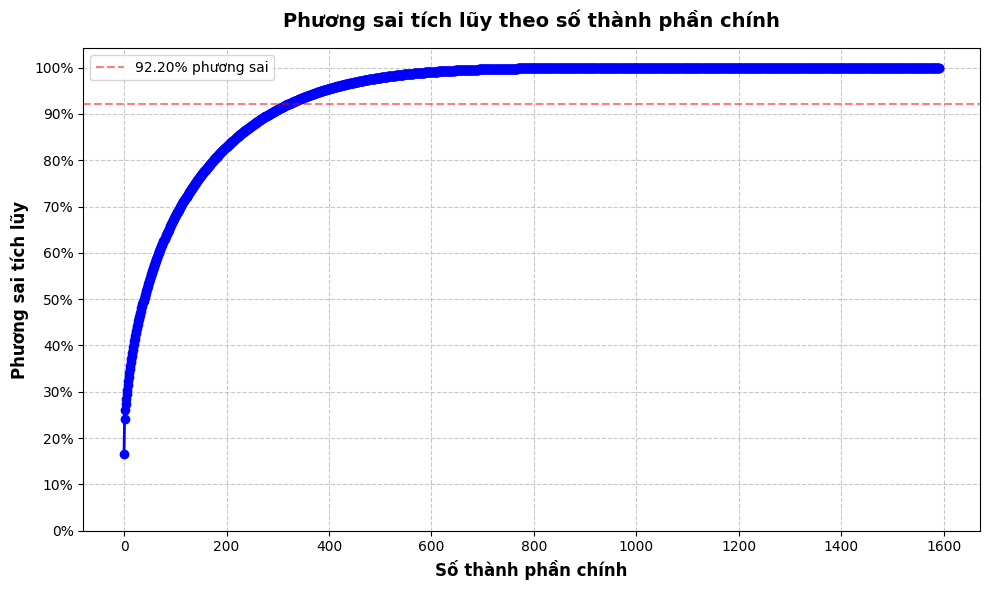

 - Sử dụng Elbow Method chọn số thành phần PCA là: 323 (với 92.20% phương sai tích lũy)

Bước 4.1: Phân cụm với KMeans ...
 - KMeans đã chạy 12 lần

Bước 4.2: Phân cụm với GaussianMixture ...
 - GaussianMixture đã chạy 34 lần

Bước 5: Đánh giá kết quả phân cụm ...
 - Kết quả KMeans:
  + Silhouette: 0.1230
  + Davies_bouldin: 2.6151
  + Accuracy: 0.5349
  + Precision: 0.4939
  + Recall: 0.3477
  + F1: 0.4081
  + Confusion Matrix:
             Pred Normal  Pred Cancer
True Normal          376          165
True Cancer          302          161

 Kết quả GaussianMixture:
  + Silhouette: 0.1255
  + Davies_bouldin: 2.6617
  + Accuracy: 0.5558
  + Precision: 0.5257
  + Recall: 0.3758
  + F1: 0.4383
  + Confusion Matrix:
             Pred Normal  Pred Cancer
True Normal          384          157
True Cancer          289          174

Bước 6: So sánh 2 mô hình ...
 - Model tốt hơn dựa trên accuracy là: GaussianMixture

Bước 7: Visualization cho GaussianMixture ...


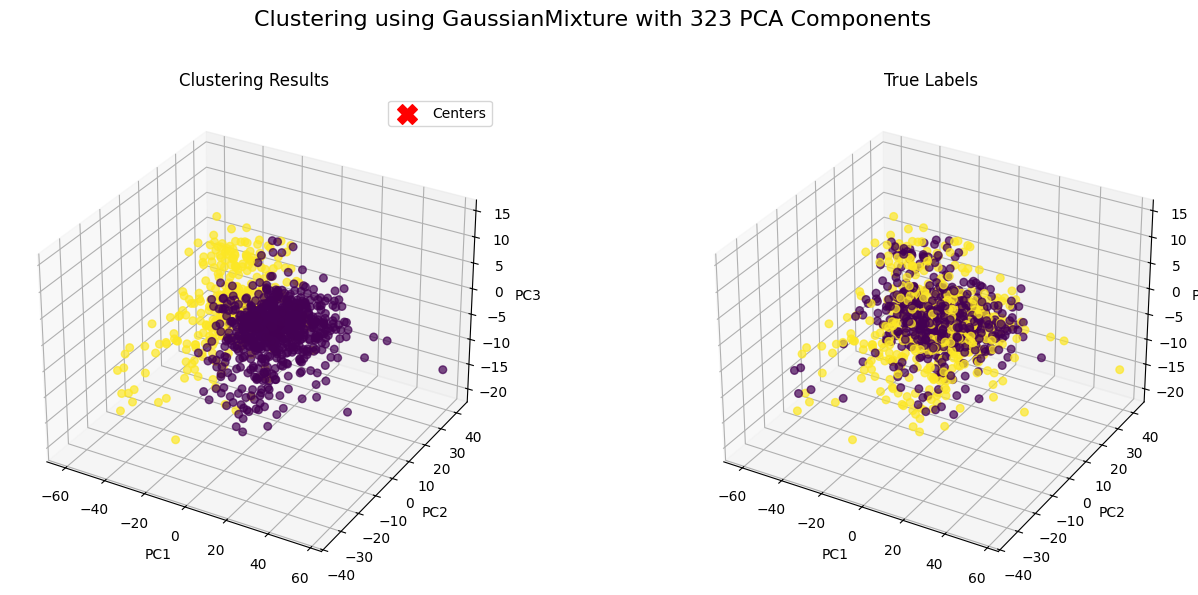

In [ ]:
best_model = clustering_pipeline(
    X,
    y=y,
    n_clusters=2,
    variance_threshold_quantile=0.01,
    correlation_threshold=0.9     ,
    pca_variance_explained_threshold=0.95
)